In [2]:
import bz2
import pandas as pd
import numpy as np
from datetime import datetime, date, time

import seaborn as sns
import matplotlib.pyplot as plt

#NLP libraries
import spacy, nltk

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
path = '/Users/Danae/Documents/Education/Master/Applied Data Analysis (CS-401)/ADA_Group_Projects/ada-2021-project-adagang'

#### Read quote/speaker dataframe

In [4]:
speaker_quotes_total = pd.read_pickle(path + '/total-data-merged.pkl.bz2', compression='bz2')
keys_most_specific = ['all lives matter','black lives matter', 'blue lives matter','campaign zero','movement for black lives',
                      "hands up, don't shoot", 'no justice, no peace','stop killing us','unarmed black man', 'white lives matter']

In [17]:
speaker_quotes_total.head(3)

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion
quoteID,,,,,,,,,,,,,,,,
2015-06-02-000948,"However, in the meantime compulsory encryption...",Chris McIntosh,Q5107420,2015-06-02,1,[computerweekly],0.8306,1977-02-20,United States of America,male,None,American football player,None,None,Chris McIntosh,None
2015-09-20-001335,A missile landed on the house of Abdul Waheed ...,Zahid Khan,Q24005455,2015-09-20,1,[tribune],0.8935,1976-01-01,None,male,None,cricketer,None,None,Zahid Khan,None
2015-10-21-003064,a remarkable demonstration of chutzpah.,Ben Bernanke,Q201795,2015-10-21,1,[washingtonpost],0.7873,1953-12-13,United States of America,male,Jewish people,"[economist, politician, professor, banker]",Republican,None,Ben Bernanke,Judaism


In [203]:
def filter_by_keywords(chunk, keywords):
    '''Return the rows of the dataframe only if the quotation contains any token in the keywords list.'''
    chunk_lower = chunk.copy()
    chunk_lower['quotation'] = chunk.quotation.str.lower()
    keys = []
    for key in keywords:
        keys.append(key.lower())
    chunk = chunk[chunk_lower.quotation.str.contains('|'.join(keys))]
    
    return chunk

In [ ]:
df_blm = filter_by_keywords(speaker_quotes_total, ['black lives matter'])
df_blm.shape

#### Run the sentiment analysis

In [495]:
quotes_sent[quotes_sent.numOccurrences>2]

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion,sentiment_scores
quoteID,,,,,,,,,,,,,,,,,
2015-11-04-005754,"Although I am not related to Sandra Bland,",Sandra Bland,Q20725687,2015-11-04,31,"[washingtonpost, washingtonpost, washingtonpos...",0.7824,NaT,United States of America,female,African Americans,None,None,None,Sandra Bland,None,0.0000
2015-03-20-054731,Michael Brown was one of those rare people who...,Andrew Sandoval,Q4758500,2015-03-20,6,"[latimes, latimes, latimes, mcclatchydc, bosto...",0.8930,NaT,United States of America,male,None,record producer,None,None,Andrew Sandoval,None,0.5789
2015-01-03-016325,It is not municipal fines that caused Michael ...,Maria Chappelle-Nadal,Q6761088,2015-01-03,6,"[seattlepi, sfgate, washingtontimes, kmov, kmb...",0.8173,1974-10-03,United States of America,female,African Americans,politician,Democrat,None,Maria Chappelle-Nadal,None,-0.8316
2015-07-28-095065,The recent death of a woman in custody reminds...,Damon Jones,Q22662263,2015-07-28,5,"[dailyvoice, dailyvoice, dailyvoice, dailyvoic...",0.9524,NaT,None,None,None,None,None,None,None,None,0.0000
2015-03-05-100532,We feel Officer Darren Wilson did not need to ...,Anthony Gray,Q48964527,2015-03-05,5,"[kens5, freep, kvue, upi, upi]",0.7261,1984-04-06,None,male,None,association football player,None,None,Anthony Gray,None,-0.5667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28-005714,"As Eric Garner's mother knows all too well, in...",Yvette Clarke,Q461679,2020-02-28,39,"[foxnews, kob, foxnews, whec, mynorthwest, nbc...",0.6892,1964-11-21,United States of America,female,African Americans,politician,Democrat,None,Yvette Clarke,Episcopal Church,-0.3612
2020-02-07-100713,"Trayvon Martin would have been 25 today,",Pete Buttigieg,Q7173106,2020-02-07,12,"[americanthinker, gopusa, independent, onenews...",0.5481,1982-01-19,United States of America,male,Maltese American,"[politician, military officer, statesperson]",Democrat,None,Pete Buttigieg,Anglicanism,0.0000
2020-01-20-066636,There's this gun rights protest that's going o...,Alexandria Ocasio-Cortez,Q55223040,2020-01-20,5,"[foxnews, foxnews, nypost, theyeshivaworld, th...",0.6948,1989-10-13,United States of America,female,None,"[politician, political activist, community org...",Democrat,None,Alexandria Ocasio-Cortez,Catholicism,0.4767


In [65]:
quotes_sent = speaker_quotes_total.copy() # dataframe to run the sentiment analysis on
#quotes_sent = df_blm.copy() # dataframe to run the sentiment analysis on

analyzer = SentimentIntensityAnalyzer() # initialize analyzer
quotes_sent['sentiment_scores'] = quotes_sent['quotation'].apply(lambda quotation: analyzer.polarity_scores(quotation)['compound'])
#quotes_sent['date'] = pd.to_datetime(quotes_sent['date'], errors='coerce')

quotes_sent.head(2)

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion,sentiment_scores
quoteID,,,,,,,,,,,,,,,,,
2015-06-02-000948,"However, in the meantime compulsory encryption...",Chris McIntosh,Q5107420,2015-06-02,1,[computerweekly],0.8306,1977-02-20,United States of America,male,None,American football player,None,None,Chris McIntosh,None,0.25
2015-09-20-001335,A missile landed on the house of Abdul Waheed ...,Zahid Khan,Q24005455,2015-09-20,1,[tribune],0.8935,1976-01-01,None,male,None,cricketer,None,None,Zahid Khan,None,0.00


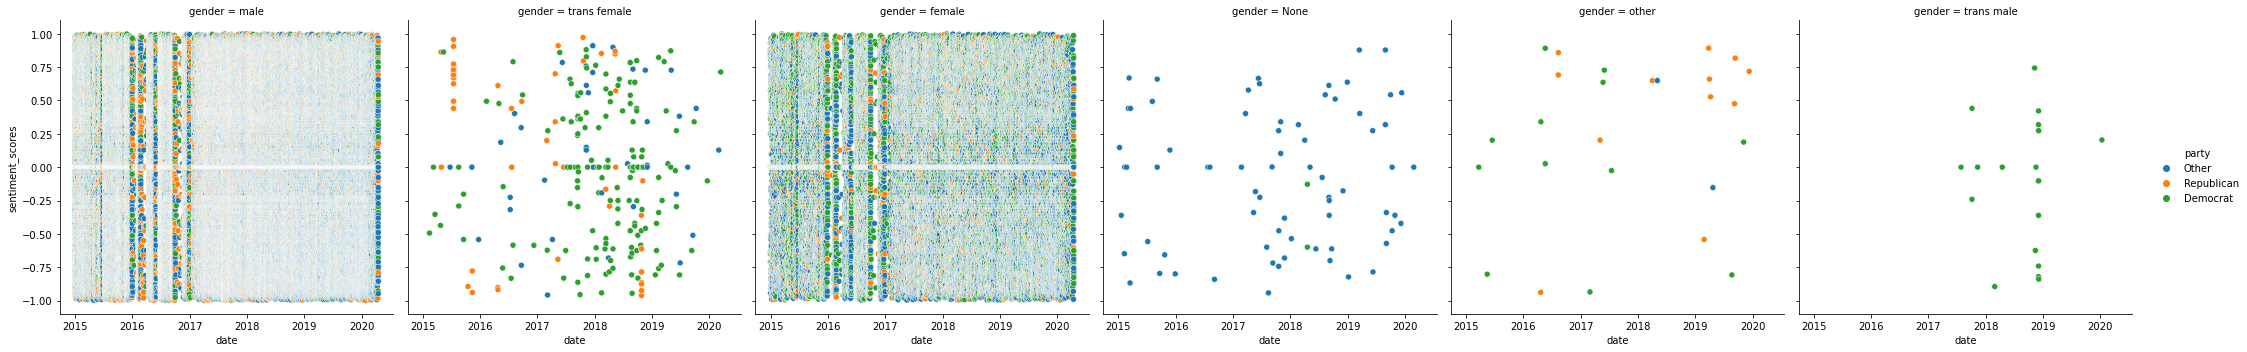

In [ ]:
plot_df = quotes_sent.copy().sort_values(by='date')
#plot_df = plot_df.groupby(plot_df['date'].dt.strftime('%Y-%m-%d'))['sentiment_scores'].mean()

#fig, ax = plt.subplots(figsize = (20,6))
sns.relplot(data=plot_df, x="date", y="sentiment_scores", col="gender", hue="party", estimator="mean")
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y %B %d"))
fig.autofmt_xdate()

In [76]:
quotes_sent[quotes_sent.speaker == "Alicia Garza"]

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion,sentiment_scores
quoteID,,,,,,,,,,,,,,,,,
2015-08-07-110350,"Unfortunately, when something becomes a signif...",Alicia Garza,Q19609542,2015-08-07,1,[vocativ],0.8018,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,0.0274
2015-07-23-046400,I want to see from all these candidates is pro...,Alicia Garza,Q19609542,2015-07-23,2,"[time, wordpress]",0.7180,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,0.1779
2015-08-09-062972,We matter. Our lives matter. Black lives matter.,Alicia Garza,Q19609542,2015-08-09,1,[theroot],0.8948,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,0.0772
2015-08-09-003802,And so Black Lives Matter has said that black ...,Alicia Garza,Q19609542,2015-08-09,1,[theroot],0.8909,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,0.5367
2015-05-04-001134,I created #BlackLivesMatter with Patrisse Cull...,Alicia Garza,Q19609542,2015-05-04,1,[kcet],0.8971,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,0.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-07-096269,What people are seeing is that there are less ...,Alicia Garza,Q19609542,2019-01-07,1,[wsws],0.7969,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,-0.2500
2019-11-04-113370,will be remembered as an enabler of white supr...,Alicia Garza,Q19609542,2019-11-04,1,[afr],0.8182,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,0.0516
2019-05-29-014397,Campaigns that fail to understand or try to re...,Alicia Garza,Q19609542,2019-05-29,1,[colorlines],0.6886,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,-0.9403


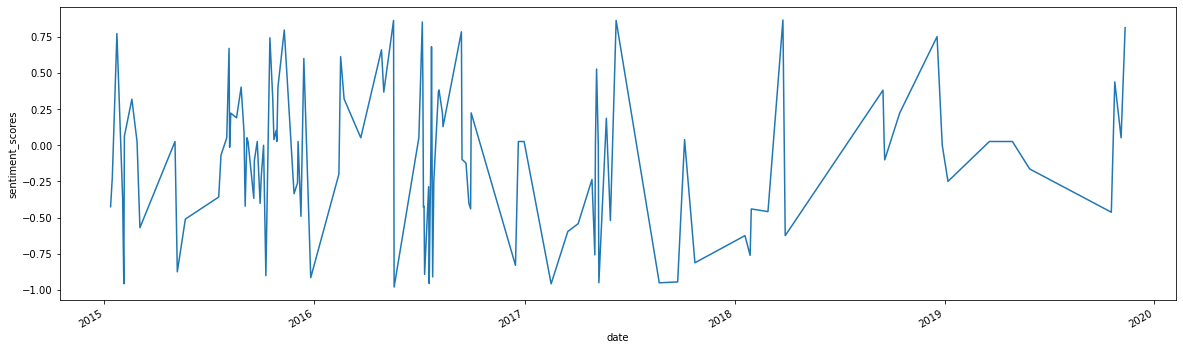

In [78]:
#plot_df = quotes_sent.copy()[['date', 'quotation', 'speaker', 'qids', 'sentiment_scores']].sort_values(by='date')
plot_df = quotes_sent[quotes_sent.speaker == "Alicia Garza"][['date', 'quotation', 'speaker', 'qids', 'sentiment_scores']].sort_values(by='date')
plot_df = plot_df.groupby(plot_df['date'])['sentiment_scores'].mean()

fig, ax = plt.subplots(figsize = (20,6))
sns.lineplot(data=plot_df, ax=ax)
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y %B %d"))
fig.autofmt_xdate()

In [ ]:
# group by columns and get the average sentiment polarity scores
group_by_cols = ["date", "party"]
plot_df = quotes_sent.copy().sort_values(by='date')
plot_df = plot_df.groupby(group_by_cols, as_index=False)['sentiment_scores'].mean()

#fig, ax = plt.subplots(figsize = (20,6))
sns.relplot(data=plot_df, x="date", y="sentiment_scores", hue="party", kind="line", row="party")
#fig.autofmt_xdate()

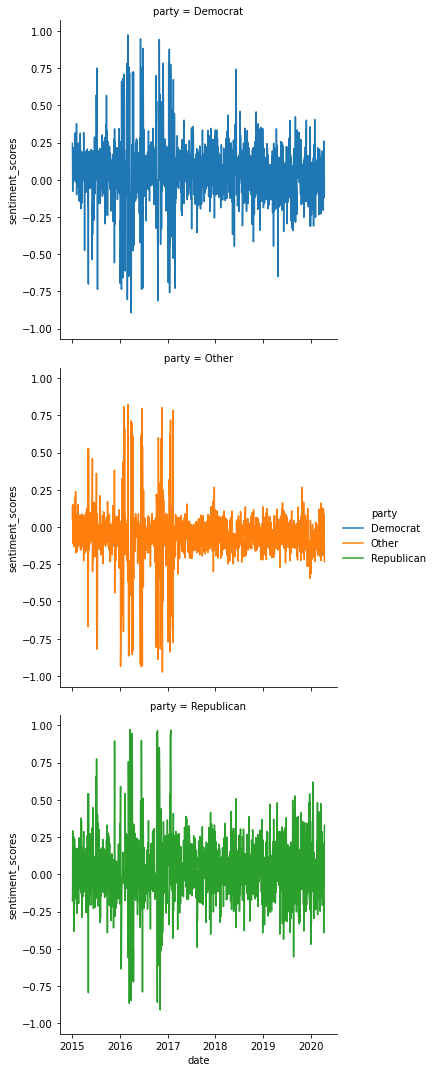

In [ ]:
# group by columns and get the average sentiment polarity scores
group_by_cols = ["date", "party"]
plot_df = quotes_sent.copy().sort_values(by='date')
plot_df = plot_df.groupby(group_by_cols, as_index=False)['sentiment_scores'].mean()

#fig, ax = plt.subplots(figsize = (20,6))
sns.relplot(data=plot_df, x="date", y="sentiment_scores", hue="party", kind="line", row="party")
#fig.autofmt_xdate()

In [96]:
quotes = quotes_sent[quotes_sent.speaker == "Alicia Garza"]
#quotes = quotes.sort_values(by=['sentiment_scores'])
quotes = quotes.reindex(quotes.sentiment_scores.abs().sort_values(ascending = False).index).head(100)
quotes

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion,sentiment_scores
quoteID,,,,,,,,,,,,,,,,,
2016-05-19-141631,"When we say Black Lives Matter, we are talking...",Alicia Garza,Q19609542,2016-05-19,1,[counterpunch],0.8656,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,-0.9803
2016-07-09-055003,"This happens too often, and we always cry, and...",Alicia Garza,Q19609542,2016-07-09,2,"[huffingtonpost, huffingtonpost]",0.6529,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,-0.9593
2017-02-16-039071,I waited for him to discuss or even announce a...,Alicia Garza,Q19609542,2017-02-16,1,[ibtimes],0.7902,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,-0.9579
2015-02-04-000364,a call to action for black people after Trayvo...,Alicia Garza,Q19609542,2015-02-04,1,[frostillustrated],0.7608,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,-0.9578
2016-07-19-001180,a battle that we are consistently having to fi...,Alicia Garza,Q19609542,2016-07-19,1,[forgetthebox],0.9153,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,-0.9559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-15-017996,Even though Black Lives Matter gets talked abo...,Alicia Garza,Q19609542,2016-02-15,1,[truth-out],0.9232,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,0.4215
2016-07-10-059784,We don't deserve to be killed with impunity. W...,Alicia Garza,Q19609542,2016-07-10,1,[bendbulletin],0.8600,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,-0.4215
2016-07-08-007416,are vowing to protect white supremacy and geno...,Alicia Garza,Q19609542,2016-07-08,4,"[thetrumpet, thetrumpet, thetrumpet, thetrumpet]",0.7704,1981-01-04,United States of America,female,None,activist,None,None,Alicia Garza,None,0.4215


In [ ]:
for i in quotes.index:
    #print(quotes_sent.loc[i, "quotation"])
    #print(quotes_sent.loc[i, "sentiment_scores"])
    #print("\n")

#### Named entity recognition

In [165]:
def get_named_entities(df, entity_types):
    ''' Does named entity recognition for every quote of a dataframe and puts the detected entities in a dictionnary. '''
    nlp = spacy.load('en_core_web_sm')
    
    # gets filled with lists of named entities of same type
    entity_dict = {}
    
    i = 0
    for quote in df.quotation:
        i = i + 1
        if i%10000 == 0:
            print(i)
        
        doc = nlp(quote)
        
        for ent in doc.ents:
            # if a quote token gets identified as a named entity and its type is included in the list entity_types
            if ent.label_ in entity_types:
                # if a previously identitied named entity was of the same entity type
                if ent.label_ in entity_dict:
                    entity_dict[ent.label_].append(ent.text)
                # if no other named entity identitied before was of the same entity type
                else:
                    entity_dict[ent.label_] = [ent.text]
    
    return entity_dict


def count_dict_entities(entities_dict, entity_types):
    ''' Counts the frequency of the entities in the dictionary. '''
    # gets filled with lists of pairs [entity, number of occurences] of same type
    entity_freq_dict = {}
    
    for key in entities_dict.keys():
        # for every entity of the list
        for ent in entities_dict[key]:
            # if key isn't in the new frequence dictionnary
            if key not in entity_freq_dict.keys():
                entity_freq_dict[key] = [[ent, entities[key].count(ent)]]
            else:
                # if entity has never been seen and counted (not written yet in the freq dictionnary)
                if [ent, entities[key].count(ent)] not in entity_freq_dict[key]:
                    entity_freq_dict[key].append([ent, entities[key].count(ent)])
    
    return entity_freq_dict


def get_entity_type_occurences(entity_type, entity_freq_dict):
    ''' Gets the number of entity occurences for a specific entity type from a frequence dictionary.'''
    ''' Returns a dataframe. '''
    
    # if input key not in input dictionnary, raise error
    if entity_type not in entity_freq_dict.keys():
        raise TypeError(f"{entity_type} isn't an entity_freq_dict key, should be either of these: {entity_freq_dict.keys()}")
    
    # select one entity type
    entity_occ_pairs = entity_freq_dict[entity_type]
    entity_name = []
    entity_occ = []
    
    for pair in entity_occ_pairs:
        entity_name.append(pair[0])
        entity_occ.append(pair[1])
    
    occurences_df = pd.DataFrame(data = { 'entityName' : entity_name,
                                         'numOccurrences' : entity_occ}
                                )
    occurences_df = occurences_df.sort_values(by=['numOccurrences'], ascending=False)

    return occurences_df

In [28]:
entity_types = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE', 'DATE']
# Does named entity recognition for every quote of a dataframe and puts the detected entities in a dictionnary
entities = get_named_entities(speaker_quotes_total.copy().head(5000), entity_types)

,entityName,numOccurrences
40,Lynch,30
73,Loretta Lynch,20
3,Ferguson,13
72,Obama,12
169,Marshawn Lynch,7
...,...,...
347,Aussies Controversy,1
348,Mirwaiz,1
349,Brendon McCullum's,1
350,Nawaz Sharif,1


In [ ]:
# Counts the frequency of the entities in the dictionary
entity_freq = count_dict_entities(entities, entity_types)
# Gets the number of entity occurences for a specific entity type from a frequence dictionary and returns a dataframe
get_entity_type_occurences('PERSON', entity_freq)

In [26]:
speaker_quotes_total.copy().shape

(753228, 16)

In [98]:
police_df = filter_by_keywords(speaker_quotes_total, ['police'])
police_df.shape

(425363, 16)

In [99]:
quotes_sent = police_df.copy() # dataframe to run the sentiment analysis on

analyzer = SentimentIntensityAnalyzer() # initialize analyzer
quotes_sent['sentiment_scores'] = quotes_sent['quotation'].apply(lambda quotation: analyzer.polarity_scores(quotation)['compound'])
#quotes_sent['date'] = pd.to_datetime(quotes_sent['date'], errors='coerce')

quotes_sent.head(2)

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion,sentiment_scores
quoteID,,,,,,,,,,,,,,,,,
2015-06-02-000948,"However, in the meantime compulsory encryption...",Chris McIntosh,Q5107420,2015-06-02,1,[computerweekly],0.8306,1977-02-20,United States of America,male,None,American football player,None,None,Chris McIntosh,None,0.25
2015-09-20-001335,A missile landed on the house of Abdul Waheed ...,Zahid Khan,Q24005455,2015-09-20,1,[tribune],0.8935,1976-01-01,None,male,None,cricketer,None,None,Zahid Khan,None,0.00


In [171]:
def select_time_window(df, start=None, end=None):
    ''' Selects rows containing quotes cited during a specific time window. '''
    ''' start and end should be of type datetime() '''
    
    df = df.copy()
    
    if (isinstance(start, date) is False) & (start is not None):
        raise TypeError(f"start = {start}: it is neither of type datetime nor None")
    if (isinstance(end, date) is False) & (end is not None):
        raise TypeError(f"end = {end}: it is neither of type datetime nor None")
    
    if start is not None:
        df = df[df['date'] >= start.date()]
    if end is not None:
        df = df[df['date'] <= end.date()]
        
    return df

speaker_quotes_window = select_time_window(speaker_quotes_total, start=datetime(2016, 4, 1), end=datetime(2016, 8, 1))

In [172]:
speaker_quotes_window.shape

(44347, 16)

In [173]:
entity_types = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE']
# Does named entity recognition for every quote of a dataframe and puts the detected entities in a dictionnary
entities = get_named_entities(speaker_quotes_window.copy(), entity_types)

10000
20000
30000
40000


In [199]:
# Counts the frequency of the entities in the dictionary
entity_freq = count_dict_entities(entities, entity_types)
# Gets the number of entity occurences for a specific entity type from a frequence dictionary and returns a dataframe
get_entity_type_occurences('ORG', entity_freq)

,entityName,numOccurrences
22,BLM,194
6,FBI,192
31,Congress,191
190,Trump,179
98,Philando Castile,157
...,...,...
3003,PinkNews,1
3002,Trimbakeshwar,1
3001,Arlington National Cemetery,1
3000,Defense Department,1


In [200]:
occ = get_entity_type_occurences('ORG', entity_freq)
#occ = occ[occ['numOccurrences'] > 10]
#np.array(occ.entityName)
occ

,entityName,numOccurrences
22,BLM,194
6,FBI,192
31,Congress,191
190,Trump,179
98,Philando Castile,157
...,...,...
3003,PinkNews,1
3002,Trimbakeshwar,1
3001,Arlington National Cemetery,1
3000,Defense Department,1


In [207]:
# top names of police brutality victims appearing in entity recognition
big_names = ['Tamir Rice','Trayvon Martin', 'Michael Brown','Eric Garner','Alton Sterling','Sandra Bland','Laquan McDonald']

big_names_df = filter_by_keywords(speaker_quotes_total, big_names)
quotes_sent = big_names_df.copy() 

analyzer = SentimentIntensityAnalyzer() # initialize analyzer
quotes_sent['sentiment_scores'] = quotes_sent['quotation'].apply(lambda quotation: analyzer.polarity_scores(quotation)['compound'])
#quotes_sent['date'] = pd.to_datetime(quotes_sent['date'], errors='coerce')

quotes_sent.quotation.values().head(10)

TypeError: 'numpy.ndarray' object is not callable

In [496]:
#quotes_sent.reindex(quotes_sent.sentiment_scores.abs().sort_values(ascending=False).index)
#for i in quotes_sent.reindex(quotes_sent.sentiment_scores.abs().sort_values(ascending=False).index).head(5).index.values:
#    print(quotes_sent.loc[i, 'quotation'])
#    print(quotes_sent.loc[i, 'sentiment_scores'])
#    print("\n")

In [ ]:
df_blm = filter_by_keywords(speaker_quotes_total, ['black lives matter'])

quotes_sent = speaker_quotes_total.copy() # dataframe to run the sentiment analysis on
#quotes_sent = df_blm.copy() # dataframe to run the sentiment analysis on

analyzer = SentimentIntensityAnalyzer() # initialize analyzer
quotes_sent['sentiment_scores'] = quotes_sent['quotation'].apply(lambda quotation: analyzer.polarity_scores(quotation)['compound'])
#quotes_sent['date'] = pd.to_datetime(quotes_sent['date'], errors='coerce')

quotes_sent.head(2)

#### Semantic analysis based on lexical categories

In [227]:
from empath import Empath

In [234]:
lexicon = Empath()

In [330]:
keys = list(lexicon.cats)
categories_count = dict(zip(keys, [0]*len(keys)))

for quote in speaker_quotes_window.quotation:
    empath_features = lexicon.analyze(quote, normalize=False)
    categories_count = {cat: categories_count[cat]+1 if empath_features[cat]!=0 else categories_count[cat] for cat in categories_count}
categories_count = {k: v for k, v in sorted(categories_count.items(), key=lambda item: item[1], reverse=True)}

In [331]:
dict(list(categories_count.items())[0:20])

{'crime': 14205,
 'dispute': 12110,
 'government': 11721,
 'stealing': 11516,
 'law': 11199,
 'power': 9755,
 'business': 8721,
 'white_collar_job': 8191,
 'negative_emotion': 8078,
 'speaking': 7253,
 'giving': 7108,
 'communication': 7103,
 'work': 6336,
 'help': 6302,
 'positive_emotion': 6290,
 'fight': 5994,
 'aggression': 5538,
 'violence': 5495,
 'trust': 5452,
 'leader': 5293}

In [366]:
keys = list(lexicon.cats)
categories_normalized = dict(zip(keys, [0]*len(keys)))

for quote in speaker_quotes_window.quotation:
    empath_features = lexicon.analyze(quote, normalize=False)
    categories_normalized = {cat: categories_normalized[cat]+empath_features[cat] for cat in categories_normalized}
categories_normalized = {k: v for k, v in sorted(categories_normalized.items(), key=lambda item: item[1], reverse=True)}

In [367]:
dict(list(categories_normalized.items())[0:20])

{'crime': 24103.0,
 'government': 19930.0,
 'law': 19378.0,
 'stealing': 14994.0,
 'dispute': 14627.0,
 'power': 11666.0,
 'business': 11454.0,
 'negative_emotion': 10418.0,
 'white_collar_job': 9373.0,
 'giving': 9023.0,
 'speaking': 8975.0,
 'communication': 8742.0,
 'help': 7907.0,
 'positive_emotion': 7750.0,
 'work': 7647.0,
 'fight': 7085.0,
 'aggression': 6857.0,
 'violence': 6599.0,
 'trust': 6368.0,
 'leader': 6330.0}

In [487]:
keys = list(lexicon.cats)
categories = dict(zip(keys, [0]*len(keys)))

for quote in speaker_quotes_window.quotation:
    empath_features = lexicon.analyze(quote, normalize=True)
    categories = {cat: categories[cat]+empath_features[cat] for cat in categories}
categories = {k: v for k, v in sorted(categories.items(), key=lambda item: item[1], reverse=True)}
dict(list(categories_normalized.items())[0:20])

{'crime': 24103.0,
 'government': 19930.0,
 'law': 19378.0,
 'stealing': 14994.0,
 'dispute': 14627.0,
 'power': 11666.0,
 'business': 11454.0,
 'negative_emotion': 10418.0,
 'white_collar_job': 9373.0,
 'giving': 9023.0,
 'speaking': 8975.0,
 'communication': 8742.0,
 'help': 7907.0,
 'positive_emotion': 7750.0,
 'work': 7647.0,
 'fight': 7085.0,
 'aggression': 6857.0,
 'violence': 6599.0,
 'trust': 6368.0,
 'leader': 6330.0}

##### The evolution of the top 20 most frequently seen topics

In [488]:
def semantic_analysis(row, quote, categories):
    empath_values = list(lexicon.analyze(row[quote], categories = categories, normalize=True).values())
    row[categories] = empath_values
    
    return row

In [491]:
# select the top 20 categories
top_20_categories = dict(list(categories.items())[0:20])
top_20_categories = list(top_20_categories.keys())

### do semantic analysis for each quotes only on those categories
cols = ['quotation'] + top_20_categories
# create new dataframe with one column per topic
topic_evolution = speaker_quotes_window.copy()[['quotation']].reindex(columns=cols)

for index, row in topic_evolution.iterrows():
    topic_evolution.loc[index] = semantic_analysis(row, 'quotation', top_20_categories)
topic_evolution.head(3)

,quotation,crime,government,law,dispute,stealing,power,white_collar_job,business,negative_emotion,...,giving,communication,help,fight,positive_emotion,aggression,work,violence,prison,trust
quoteID,,,,,,,,,,,,,,,,,,,,,
2016-07-21-005544,"All the police officers that we work with, we ...",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.000000,...,0.000000,0.0,0.043478,0.000000,0.043478,0.0,0.043478,0.0,0.000000,0.043478
2016-05-17-007078,Anything that we can do to help keep a police ...,0.021739,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.021739,...,0.021739,0.0,0.021739,0.000000,0.021739,0.0,0.021739,0.0,0.021739,0.000000
2016-07-10-005970,Brown's former police partner was killed in an...,0.020408,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020408,...,0.000000,0.0,0.020408,0.020408,0.000000,0.0,0.000000,0.0,0.020408,0.000000


In [492]:
# merge the lexical categories scores with the speaker's attributes
topic_ev = topic_evolution.copy()

topic_ev = speaker_quotes_window.merge(topic_ev[top_20_categories], left_index=True, right_index=True)
topic_ev.groupby(['date', 'party'])[top_20_categories].mean().head(5)

crime  government       law   dispute  stealing  \
date       party                                                            
2016-04-01 Other       0.060428    0.069935  0.058824  0.019608  0.030719   
           Republican  0.000000    0.000000  0.000000  0.000000  0.000000   
2016-04-04 Other       0.030303    0.000000  0.030303  0.030303  0.000000   
2016-04-05 Democrat    0.044118    0.058824  0.029412  0.014706  0.014706   
           Republican  0.066667    0.100000  0.100000  0.033333  0.033333   

                          power  white_collar_job  business  negative_emotion  \
date       party                                                                
2016-04-01 Other       0.019608          0.019608  0.019608               0.0   
           Republican  0.000000          0.000000  0.000000               0.0   
2016-04-04 Other       0.030303          0.000000  0.000000               0.0   
2016-04-05 Democrat    0.014706          0.014706  0.029412               0.0   
           Republican  0.033333          0.033333  0.033333               0.0   

                       speaking    giving  communication      help     fight  \
date       party                                                               
2016-04-01 Other       0.030719  0.039216       0.030719  0.010101  0.000000   
           Republican  0.000000  0.000000       0.000000  0.000000  0.000000   
2016-04-04 Other       0.000000  0.000000       0.000000  0.000000  0.121212   
2016-04-05 Democrat    0.007812  0.000000       0.007812  0.014706  0.000000   
           Republican  0.000000  0.033333       0.000000  0.000000  0.000000   

                       positive_emotion  aggression      work  violence  \
date       party                                                          
2016-04-01 Other               0.000000    0.000000  0.000000       0.0   
           Republican          0.000000    0.000000  0.000000       0.0   
2016-04-04 Other               0.000000    0.060606  0.000000       0.0   
2016-04-05 Democrat            0.014706    0.000000  0.014706       0.0   
           Republican          0.033333    0.000000  0.033333       0.0   

                         prison     trust  
date       party                           
2016-04-01 Other       0.010101  0.000000  
           Republican  0.000000  0.000000  
2016-04-04 Other       0.000000  0.030303  
2016-04-05 Democrat    0.000000  0.000000  
           Republican  0.000000  0.000000

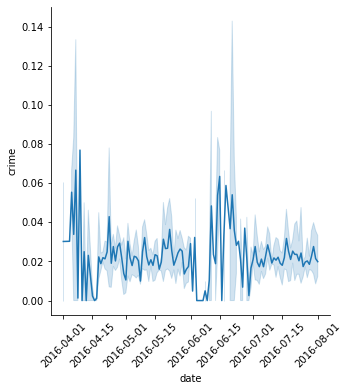

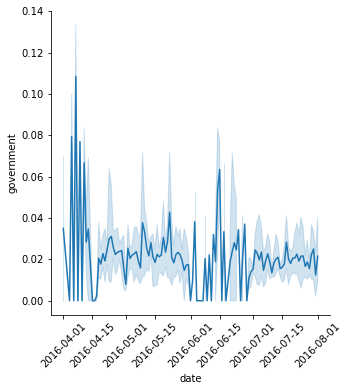

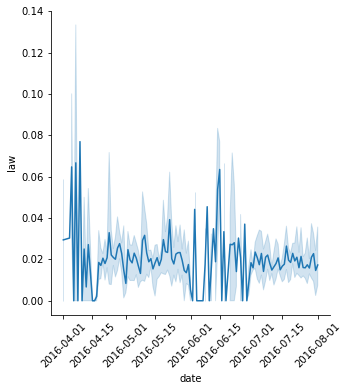

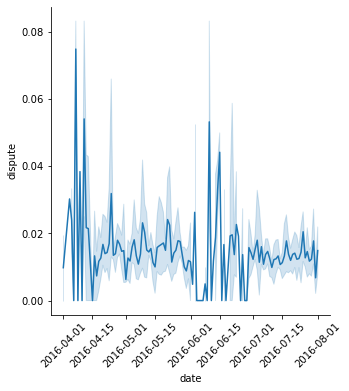

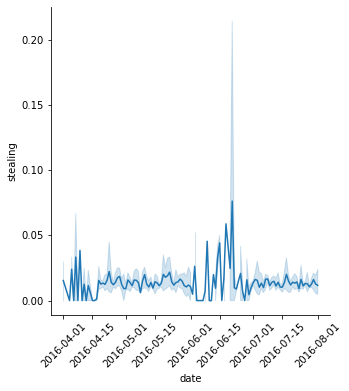

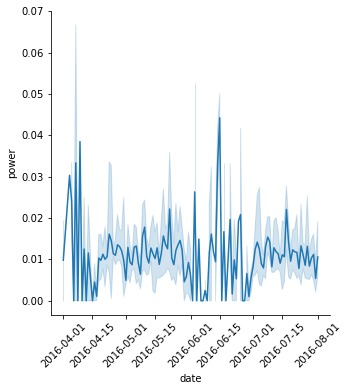

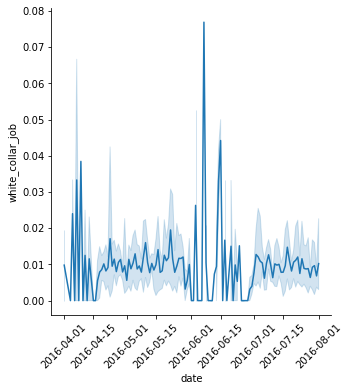

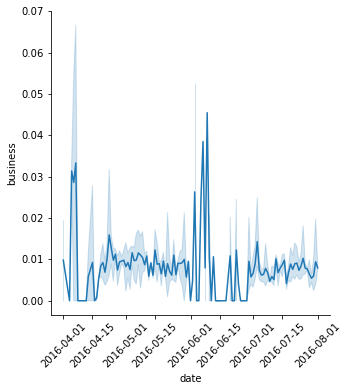

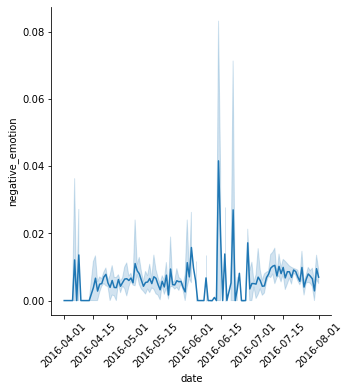

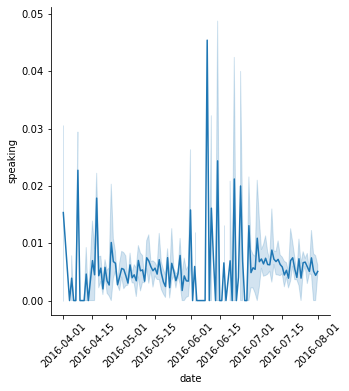

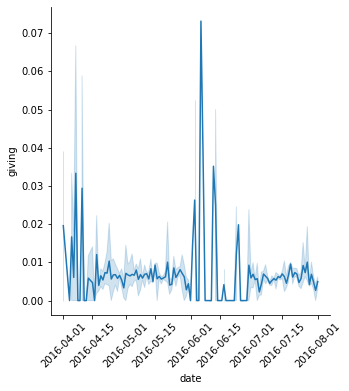

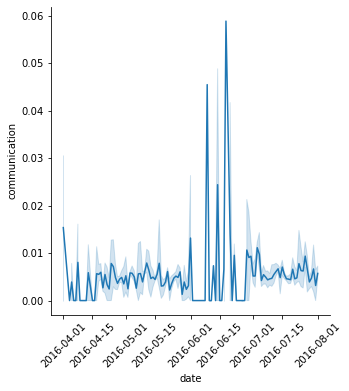

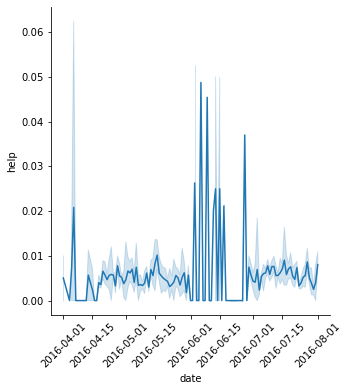

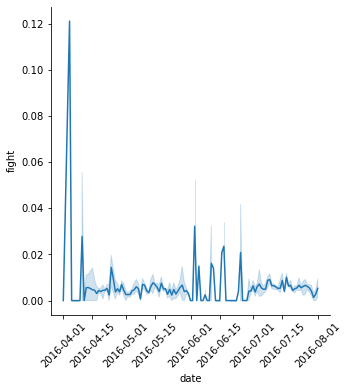

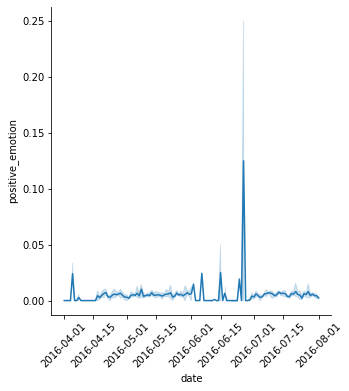

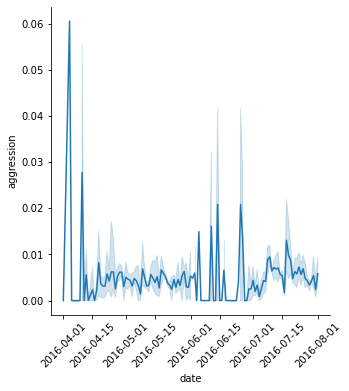

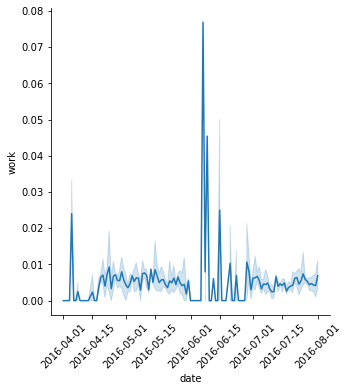

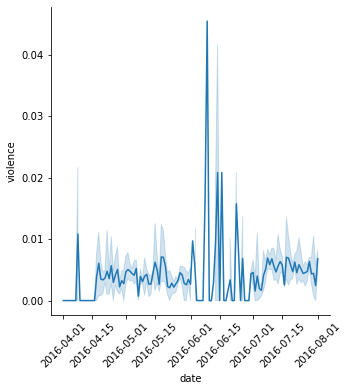

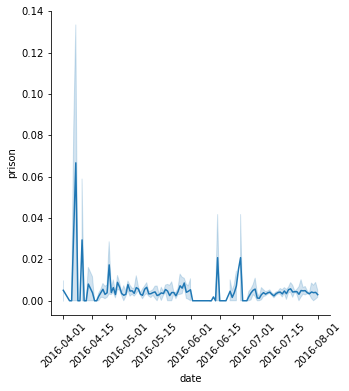

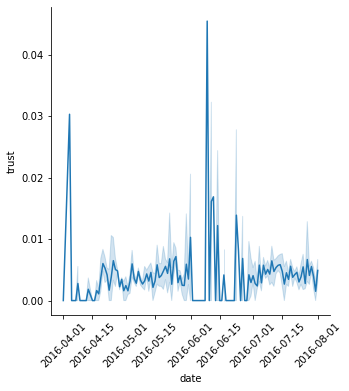

In [493]:
plot_df = topic_ev.groupby(['date', 'party'])[top_20_categories].mean()

#sns.relplot(data=plot_df, x="date", y="negative_emotion", hue="party", kind="line", row="party")
for cat in top_20_categories:
    sns.relplot(data=plot_df, x="date", y=cat, kind="line")
    plt.xticks(rotation=45)

In [443]:
#topic_evolution.apply(lambda row: semantic_analysis(row, quote='quotation', categories=top_20_categories))

##### Create custom categories based on seed terms

In [483]:
lexicon.create_category("blm", ["black_lives_matter"], model="reddit")
big_names = ['Tamir Rice','Trayvon Martin', 'Michael Brown','Eric Garner','Alton Sterling','Sandra Bland','Laquan McDonald']

["black_lives_matter", "black_lives", "lives_matter", "Black_Lives_Matter", "police_brutality", "white_lives", "racial_issue", "police_violence", "white_cops", "protesting", "black_people", "black_community", "black_violence", "systematic_racism", "black_folks", "black_activists", "black_power", "racial_injustice", "institutional_racism", "systemic_racism", "white_racists", "racial_profiling", "black_criminals", "white_pride", "blacklivesmatter", "racial_inequality", "actual_racism", "peaceful_protesting", "institutionalized_racism", "lynching", "racial_violence", "white_racism", "violent_rioters", "race_issue", "white_liberals", "white_folks", "white_police_officers", "white_people", "NAACP", "black-on-black_crime", "white_privilege", "only_black_people", "white_rights", "white_power", "non-black_people", "black_youths", "racist_cops", "white_oppression", "colored_people", "BlackLivesMatter", "Al_Sharpton", "KKK_members", "dead_cops", "black_crime", "white_supremacy", "white_cop", "ra

In [484]:
lexicon.create_category("blm", ["black_lives_matter"], model="nytimes")

[]
